<a href="https://colab.research.google.com/github/vinay010487/StyleGAN/blob/main/StyleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/jeffheaton/present/blob/master/youtube/gan/heatonresearch_gan_kit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
from google.colab import files
import torch

!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "/content/stylegan2-ada-pytorch")

import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import cv2
import numpy as np

def display_lowres(img):
  plt.imshow(img)
  plt.title('source-gan')
  plt.show()

def seed2vec(g, seed):
  return np.random.RandomState(seed).randn(1, g.z_dim)

def load_vec(filename):
  result = np.load(filename)
  return result if 'w' not in result else result['w']
  
def save_vec(filename, lvec):
  numpy.save(filename,lvec)

def to_image(img):
  return PIL.Image.fromarray(img, 'RGB')

def render_gan(G, device, lvec, label=None, truncation_psi=1, noise_mode='const'):
  # noise mode 'const', 'random', 'none'
  z = torch.from_numpy(lvec).to(device)
  if label is None: label = torch.zeros([1, G.c_dim], device=device)
  if len(lvec.shape) == 2:
    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  else:
    img = G.synthesis(z, noise_mode=noise_mode)
  
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

--2021-12-01 17:36:24--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M  19.7MB/s    in 0.3s    

2021-12-01 17:36:25 (19.7 MB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]

bzip2: Output file shape_predictor_5_face_landmarks.dat already exists.
fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


# Accessing Data

### Mount Google Drive (GDRIVE)

In [ ]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


### Upload an Image


In [ ]:
import os
from google.colab import files

uploaded = files.upload()

for k, v in uploaded.items():
  _, ext = os.path.splitext(k)
  print(f"You uploaded /content/{k}")

Saving IMG_1541.JPG to IMG_1541.JPG
You uploaded /content/IMG_1541.JPG


### Download Image or File

In [ ]:
from google.colab import files
files.download("/content/Vinay.JPG") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Load a Pretrained GAN

In [ ]:
STYLEGAN2_PKL_URL = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-fish/releases/download/1.0.0/fish-gan-2020-12-09.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-70s-scifi/releases/download/v1/70s-scifi-gan-2020-12-12.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-merry-gan-mas/releases/download/v1/christmas-gan-2020-12-03.pkl"
#STYLEGAN2_PKL_URL = "https://github.com/jeffheaton/pretrained-gan-minecraft/releases/download/v1/minecraft-gan-2020-12-22.pkl"

device = torch.device('cuda')
with dnnlib.util.open_url(STYLEGAN2_PKL_URL) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

# Generate GAN Images from Seeds

Generating image for seed 1000 (0/3) ...


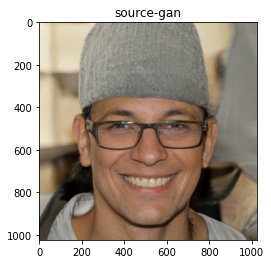

Generating image for seed 1001 (1/3) ...


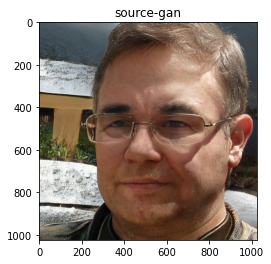

Generating image for seed 1002 (2/3) ...


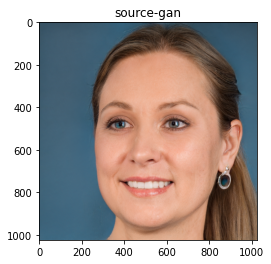

In [ ]:
seeds = [1000,1001,1002]
OUTDIR = "/content/seeds"

# Create directory
try:
    os.makedirs(OUTDIR)
except OSError:
    pass

# Generate images.

for seed_idx, seed in enumerate(seeds):
  print('Generating image for seed %d (%d/%d) ...' % (seed, seed_idx, len(seeds)))
  lv = seed2vec(G, seed)
  img = render_gan(G, device, lv)
  img.save(f'{OUTDIR}/seed{seed:04d}.png') # Save it
  #display(img2) # Display hi-res


## Load a Saved Latent Vector and Display

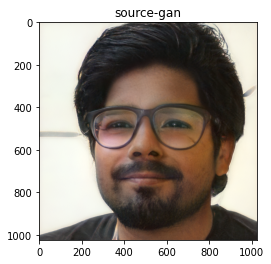

In [35]:
lvec = load_vec('/content/vinay_w.npz')
img = render_gan(G, device, lvec)
display_lowres(img)

# Preprocess Images for Best StyleGAN Results

The following are helper functions for the preprocessing.

In [ ]:
import cv2
import numpy as np
from PIL import Image
import dlib

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

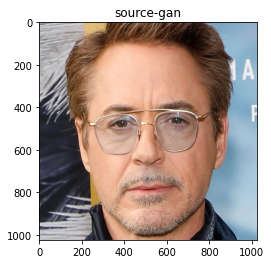

In [ ]:
IMAGE_NAME = '/content/tony.jpg'
TARGET_NAME = '/content/tony-cropped.jpg'

image = cv2.imread(IMAGE_NAME)
if image is None:
    raise ValueError("Source image not found")

cropped_image = crop_stylegan(image)
cv2.imwrite(TARGET_NAME, cropped_image)
cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)
display_lowres(cropped_image)

# Convert Image to a GAN

First, we convert the source to a GAN latent vector.  This process will take several minutes.

In [ ]:
SOURCE_NAME = "/content/tony-cropped.jpg"
OUT = "/content/"

cmd = f"python /content/stylegan2-ada-pytorch/projector.py --seed 303 --save-video 0 --num-steps 1000 --outdir={OUT} --target={SOURCE_NAME} --network={STYLEGAN2_PKL_URL}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.64 loss 24569.53
step    2/1000: dist 0.66 loss 27642.88
step    3/1000: dist 0.56 loss 27167.59
step    4/1000: dist 0.53 loss 26253.65
step    5/1000: dist 0.58 loss 24958.55
step    6/1000: dist 0.57 loss 23356.13
step    7/1000: dist 0.61 loss 21513.78
step    8/1000: dist 0.61 loss 19486.13
step    9/1000: dist 0.61 loss 17342.26
step   10/1000: dist 0.55 loss 15145.47
step   11/1000: dist 0.56 loss 12946.13
step   12/1000: dist 0.57 loss 10817.92
step   13/1000: dist 0.51 loss 8803.68
step   14/1000: dist 0.56 loss 6949.03
step   15/1000: dist 0.51 loss 5315.46
step   16/1000: dist 0.53 loss 3971.76
step   17/1000: dist 0.56 loss 2944.88
step   18/1000: dist 0.55 loss 2212.48
step   19/1000: dist 0

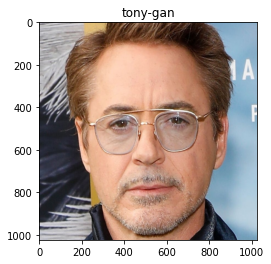

In [37]:
import cv2
import os
from matplotlib import pyplot as plt

img_gan_source = cv2.imread(os.path.join(OUT,'tony-cropped.jpg'))
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('tony-gan')
plt.show()

# Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

In [ ]:
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

STEPS = 150
FPS = 30
FREEZE_STEPS = 30

lvec = [
  np.load('/content/vinay_w.npz')['w'],
  np.load('/content/projected_w.npz')['w']
]

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device) # type: ignore

target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, codec='libx264', bitrate='16M')

for i in range(len(lvec)-1):
  lvec1 = lvec[i]
  lvec2 = lvec[i+1]

  diff = lvec2 - lvec1
  step = diff / STEPS
  current = lvec1.copy()

  for j in tqdm(range(STEPS)):
    z = torch.from_numpy(current).to(device)
    synth_image = G.synthesis(z, noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()

    repeat = FREEZE_STEPS if (j==0 and i==0) or (j==(STEPS-1) and i==(len(lvec)-2)) else 1
    
    for i in range(repeat):
      video.append_data(synth_image)
    current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

step1-convert video to multipe frames 

step2-creating the folder

step3- moving the frames in one foloder and ziping  and downloading it 

In [ ]:
import cv2
vidcap = cv2.VideoCapture("/content/movie.mp4")
success,image = vidcap.read()
count = 0
success = True
while success:
  success,image = vidcap.read()
  cv2.imwrite("frame%d.jpg" % count, image)     # save frame as JPEG file
  if cv2.waitKey(10) == 27:                     # exit if Escape is hit
      break
  count += 1

error: ignored

In [ ]:
!mkdir extracted-gan

In [ ]:
!mv frame{201..206}.jpg /content/extracted-gan/

In [ ]:
!zip -r /content/extracted-gan.zip /content/extracted-gan/

# Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train a GAN from Images

I have an entire notebook for [this](https://github.com/jeffheaton/present/blob/master/youtube/gan/colab_gan_train.ipynb).

# Finetune an Image

If you find a seed that you like, you can fine tune it by adjusting the latent vector directly.  First, choose the seed to finetune.

In [ ]:
START_SEED = 3172

current = seed2vec(Gs, START_SEED)

Next, generate display the current vector. You will return to this point for each iteration of the finetuning.

In [ ]:
init_random_state(Gs, 10)
img = generate_image(Gs, current, 1.0)

SCALE = 0.5
display_image(img, SCALE)

Choose an explore size, this is the number of differnt potential images that will be chosen by moving in 10 different directions.  Run this code once initially, and then again anytime you wish to change the 10 directions you are exploring.  You might change the 10 directions if you are no longer seeing improvements.

In [ ]:
EXPLORE_SIZE = 25

explore = []
for i in range(EXPLORE_SIZE):
  explore.append( np.random.rand(1, 512) - 0.5 )

In [ ]:
# Choose the direction to move.  Choose -1 for the initial iteration.   
MOVE_DIRECTION = -1
SCALE = 0.5

if MOVE_DIRECTION >=0:
  current = current + explore[MOVE_DIRECTION]

for i, mv in enumerate(explore):
  print(f"Direction {i}")
  init_random_state(Gs, 10)
  z = current + mv
  img = generate_image(Gs, z, 1.0)
  display_image(img, SCALE)